<a href="https://colab.research.google.com/github/sainik-khaddar/NOOB-PROJECTS/blob/main/Recommender_System_Instacart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
orders = pd.read_csv('C:/Users/Abhishek/Desktop/Roku/orders.csv')

orders = orders.loc[orders.eval_set == "prior"]

cleaning = ["eval_set","order_dow","order_hour_of_day","days_since_prior_order","order_number"]
for col in cleaning : 
    del orders[col]

In [ ]:
products = pd.read_csv('C:/Users/Abhishek/Desktop/Roku/order_products__prior.csv')

products = products[["order_id","product_id"]]

# Checking outlayer for users

In [ ]:
count_user = orders[["user_id"]]
count_user = count_user.groupby(['user_id']).size().reset_index().rename(columns={0:'count'})

In [ ]:
count_user = count_user.sort_values(['count'], ascending=[0]).reset_index()
del count_user['index']


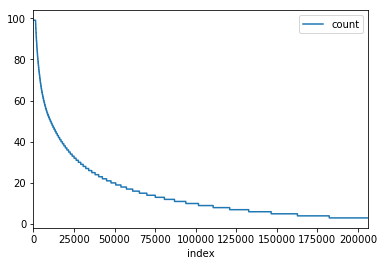

In [ ]:
count_user.reset_index().plot(x='index',y = "count")

In [ ]:
top_users = count_user[count_user["count"] >= 5] 

In [ ]:
bottom_users = count_user[count_user["count"] < 5] # dropped the users with less than 5 orders which were ~10% of the total users
bottom_users = bottom_users[['user_id']]

In [ ]:
remove_from_users = bottom_users['user_id'].tolist()


In [ ]:
order_id_index = orders[orders['user_id'].isin(remove_from_users)].order_id.tolist()

In [ ]:
orders = orders[~orders['user_id'].isin(remove_from_users)]

# Check occurences of Items

In [ ]:
products = products[~products['order_id'].isin(order_id_index)]

In [ ]:
count_products = products[["product_id"]]
count_products = count_products.groupby(['product_id']).size().reset_index().rename(columns={0:'count'})

count_products = count_products.sort_values(['count'], ascending=[0]).reset_index()
del count_products['index']

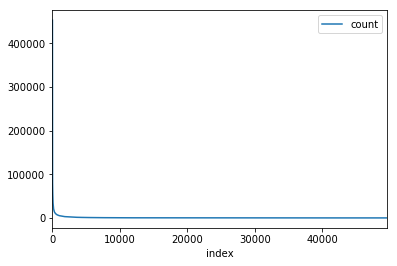

In [ ]:
count_products.reset_index().plot(x='index',y = "count")

(19566, 2)


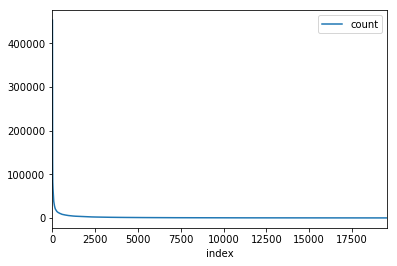

In [ ]:
top_products = count_products[count_products["count"] >= 100] # set threshold by taking the top ~90% of the items. I categorize the bottom 20% to be extremely rare
top_products = top_products.sort_values(['count'], ascending=[0]).reset_index()
del top_products['index']
top_products.reset_index().plot(x='index',y = "count")
print (top_products.shape)


In [ ]:
# keeps a track of the items to be removed (NOT TAKEN INTO CONSIDERATION)
bottom_products = count_products[count_products["count"] <=100]
bottom_products = bottom_products[['product_id']]

In [ ]:
remove_from_products = bottom_products['product_id'].tolist()

In [ ]:
products = products[~products['product_id'].isin(remove_from_products)]
# products = products[~products['product_id'].isin(remove_from_products)]

#  Making the < user,item,count > tuple

In [ ]:
# method to update product df with the user and item pair
##### DONT TOUCH THIS CODE !!!!!!!!!!!!!!!!! 

#Builds a dict of order_id with user_id

user_order_mapping = {}
for index, row in orders.iterrows():
    user_order_mapping[row['order_id']] = row['user_id'] 

In [ ]:
def f(row) : 
    return user_order_mapping[row["order_id"]]

products["user_id"] = products.apply(f,axis = 1) # convert user-items dic to df

In [ ]:
#products.to_pickle('C:/Users/Abhishek/Desktop/Roku/Pickled_final_products')

In [ ]:
#products = pd.read_pickle('C:/Users/Abhishek/Desktop/Roku/Pickled_final_products')

In [ ]:
user_item_raw = products[["user_id","product_id"]] # 

# User_item_raw stores the tuple 

In [ ]:
user_item_raw = user_item_raw.groupby(['user_id', 'product_id']).size().reset_index().rename(columns={0:'count'})

In [ ]:
user_item_raw = user_item_raw.sample(frac=1).reset_index(drop=True)[:1000000]


#  Build Matrix

In [ ]:
all_customers = list(np.sort(user_item_raw.user_id.unique())) # Get our unique customers
all_products = list(user_item_raw.product_id.unique()) # Get our unique products that were purchased
quantity = list(user_item_raw["count"]) # All of our purchases

In [ ]:
rows = user_item_raw.user_id.astype('category', categories = all_customers).cat.codes 
# Get the associated row indices

cols = user_item_raw.product_id.astype('category', categories = all_products).cat.codes 
# Get the associated column indices

purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(all_customers), len(all_products)))

In [ ]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.96615848470623

#  Split into Train and Test

In [ ]:
import random


In [ ]:
def make_train(ratings, pct_test = 0.3): 
    total = ratings.nnz
    test = sparse.csr_matrix(ratings.shape)
    train = ratings.copy()
    
    print (" selecting with all users ")
    for user in range(ratings.shape[0]): # this was to get all the users in the test set with any one element from item
        row = ratings[user, :].nonzero()[1]
        test_ratings = np.random.choice(row, size= 1 , replace=False)
        train[user, test_ratings] = 0
        test[user, test_ratings] = 1
        train.eliminate_zeros()
        
    print ("selecting with all items")
    for item in range(ratings.shape[1]):# this was to get all the items in the test set with any one element from user
        col = ratings[:,item].nonzero()[0]
        test_ratings = np.random.choice(col, size= 1 , replace=False)
        train[test_ratings, item] = 0
        test[test_ratings, item] = 1
        train.eliminate_zeros()
    print ("choosing the remaining of the (user,item) pairs")
    random_sampler = int(total*0.3) - test.nnz # the remaining of the 30 % was chosen at random from the remaining of the training and pit into the test
    
    if random_sampler > 0 : 
        
        nonzero_inds = train.nonzero() # Find the indices in the ratings data where an interaction exists
        nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
        
        #random.seed(0) # Set the random seed to zero for reproducibility
        samples = random.sample(nonzero_pairs, random_sampler) # Sample a random number of user-item pairs without replacement
        user_inds = [index[0] for index in samples] # Get the user row indices
        item_inds = [index[1] for index in samples] # Get the item column indices
        test[user_inds, item_inds] = 1
        train[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
        train.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
        


    return train, test

In [ ]:
train,test = make_train(purchases_sparse,0.3)

 selecting with all users 


C:\Users\Abhishek\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


selecting with all items
choosing the remaining of the (user,item) pairs


In [ ]:
# test.to_pickle('C:/Users/Abhishek/Desktop/Roku/test')
# train.to_pickle('C:/Users/Abhishek/Desktop/Roku/train')

AttributeError: to_pickle not found

# Ranking algorithm using ALS ( Alternating Least Squares ) Method

In [ ]:
def implicit_weighted_ALS(train, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    parameters:
    
    training_set - Our matrix of ratings with shape m x n, where m is the number of users and n is the number of items.
    Should be a sparse csr matrix to save space. 
    
    lambda_val - Used for regularization during alternating least squares. Increasing this value may increase bias
    but decrease variance. Default is 0.1. 
    
    alpha - The parameter associated with the confidence matrix discussed in the paper, where Cui = 1 + alpha*Rui. 
    The paper found a default of 40 most effective.
    
    iterations - The number of times to alternate between both user feature vector and item feature vector in
    alternating least squares. More iterations will allow better convergence at the cost of increased computation. 
    The authors found 10 iterations was sufficient, but more may be required to converge. 
    
    rank_size - The number of latent features in the user/item feature vectors. The paper recommends varying this 
    between 20-200. Increasing the number of features may overfit but could reduce bias. 
    
    seed - Set the seed for reproducible results
    
    returns:
    
    The feature vectors for users and items. The dot product of these feature vectors should give you the expected 
    "rating" at each point in your original matrix. 
    '''
    
    # first set up our confidence matrix
    
    conf = (alpha*train) # To allow the matrix to stay sparse, I will add one later when each row is taken 
                                # and converted to dense. 
    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can 
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
   
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, don't need to subtract 1 since we never added it 
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, don't need to subtract 1 since we never added it
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons. 

In [ ]:
user_vecs, item_vecs = implicit_weighted_ALS(train, lambda_val = 0.1, alpha = 15, iterations = 1,rank_size = 20)

# Get the rank score from the test set

In [ ]:
nonzero_inds = test.nonzero()
nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

In [ ]:
def rank(nonzero_pairs,user_vecs,item_vecs,test):
    sum_Rui = 0
    Numerator = 0
    for (i,j) in nonzero_pairs:
        sum_Rui += test[i,j]
        Numerator += sum_Rui * (user_vecs[i,:].dot(item_vecs[:,j]))
    return ((1.0*Numerator)/sum_Rui)*100
        
    
    

In [ ]:
rank_score = rank(nonzero_pairs,user_vecs,item_vecs,test)

In [ ]:
rank_score.todense()[0,0]

21.634696130483725